# Part Two - Convolutional Neural Net

I ended up coming back to this project because I didn't feel fully satisfied with what I made in part one. So I decided to challenge myself and create a neural network that can classify a picture of a dog or a cat. So it does not continue on with the Date Fuit Dataset, if the date dataset had pictures attached, I would have loved to continue on with it. I personally consider this to be more of an extra portion and challenge to myself, rather than a solid portion of my project. 

The goal was to create a model that can correctly classify a picture of a dog or a cat. I used the dataset "Cats and Dogs Image Classification" from Kaggle.com (https://www.kaggle.com/datasets/samuelcortinhas/cats-and-dogs-image-classification) and the Tensorflow library.

In [24]:
#importing libraries

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD

In [25]:
#allows the the zipped file within the directory to be extracted

import zipfile as zf
files = zf.ZipFile("data.zip", 'r')
files.extractall('directory to extract')
files.close()

In [26]:
#data path for dataset, folder named 'directory to extract' from .ZipFile function

train_loc = 'directory to extract/train/'
test_loc = 'directory to extract/test/'

#loading in images using tf.keras.utils.image_dataset_from_directory()

image_size = (180, 180)
batch_size = 12

train = tf.keras.utils.image_dataset_from_directory(
    train_loc,
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
    labels = 'inferred',
    validation_split = .2,
    subset = 'training'
)
val = tf.keras.utils.image_dataset_from_directory(
    train_loc,
    seed = 42,
    image_size = image_size,
    batch_size = batch_size,
    labels = 'inferred',
    validation_split = .2,
    subset= 'validation'
)
test = tf.keras.utils.image_dataset_from_directory(
    test_loc,
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
    labels = 'inferred'
)

Found 557 files belonging to 2 classes.
Using 446 files for training.
Found 557 files belonging to 2 classes.
Using 111 files for validation.
Found 140 files belonging to 2 classes.


In [27]:
#display class names

class_names = train.class_names
print(class_names)

['cats', 'dogs']


In [28]:
#displaying shape of images and batch size 

for image_batch, labels_batch in train:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(12, 180, 180, 3)
(12,)


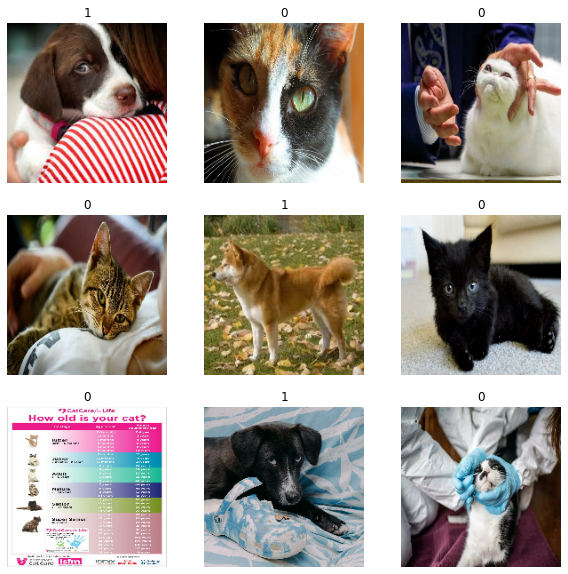

In [29]:
#credit for this plot goes to Tensorflow https://www.tensorflow.org/tutorials/images/classification#visualize_the_data 

plt.figure(figsize=(10, 10))
for pics, classes in train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(pics[i].numpy().astype("uint8"))
        plt.title(int(classes[i]))
        plt.axis("off")

Above, we can see a simple output for our training images, this plot is randomized so each time it is plotted a new set will appear. Some images in the trainging set are clearer than others, with a dog/cat being fully in the frame, and others are harder to distinguish. 

I used the Keras Sequential class for a simple stack of layers, with a sigmoid activation at the end since we only have **0 (Cats)** or **1 (Dogs)**, or what we could call a binary classification. 

In [30]:
#setting seed in Tensorflow
tf.random.set_seed(1234) 

#Build the architecture of the model

clf = Sequential([

    layers.Conv2D(32, (3,3),activation='relu', padding='same',input_shape = (180,180,3)),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(.1),
    
    
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(.1),
    
    
    layers.Conv2D(128,(3,3),activation='relu',  padding='same'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(.1),
   
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(.3),
    layers.Dense(1,activation = 'sigmoid')
    

])

clf.compile(optimizer= SGD(learning_rate = .0001,momentum = .9),
              loss='binary_crossentropy',
              metrics=['accuracy'])

clf.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 90, 90, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 45, 45, 64)        0

Now we have our model created, let's give it a run and see what happens. 

In [31]:
#fitting model to training data, takes a few minutes to run

pred = clf.fit(train, steps_per_epoch=len(train),
               validation_data=val, validation_steps=len(val),
               epochs=30, verbose=0 )

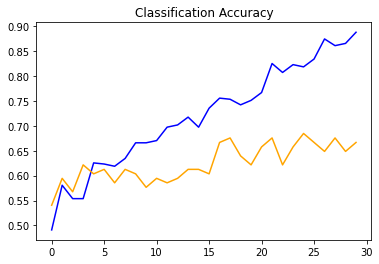

In [32]:
#plot of accuracy of trainset and val set of each epoch

plt.title('Classification Accuracy')
plt.plot(pred.history['accuracy'], color='blue', label='train')
plt.plot(pred.history['val_accuracy'], color='orange', label='val')

From our graph we can see that between 10 and 15 epochs is where our model begins to learn the training data too well and our validation accuracy begins to drop off. We have a classic example of overfitting to the training data. I will attempt to solve this issue a little further on, let's continue and see how the model performed on the test set.

Below, is our output of the model run on the test set, as we can see the accuracy is not very good, with the chances of a correct classification being only slightly better than a coin flip. Very unfortunate and dissapointing.

In [33]:
# evaluate model accuracy on test set

_, acc = clf.evaluate(test, steps=len(test), verbose=0)
print('Test Set Accuracy: %.3f' % (acc * 100.0))

Test Set Accuracy: 55.000


In [34]:
#Creating predictions with trained model, then creating list of said predictions to make confusion matrix

predictions = clf.predict(test)
y_pred= np.array((clf.predict(test) > 0.5).astype("int32"))
y_pred = y_pred.flatten()

#creating list of true class values- for confusion matrix

true_class = tf.concat([y for x, y in test], axis=0)

Text(33.0, 0.5, 'True Labels')

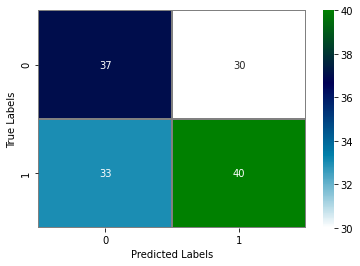

In [35]:
#plotting confusion matrix of first model

confusion_matrix(y_pred, true_class)
sns.heatmap(confusion_matrix(y_pred,true_class),cmap='ocean_r',annot=True,linewidths=2,linecolor='gray')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

As we can see above, our model does not do a very good job with classifying our test data. One possibility is that the model needs more epochs in order to learn the data more. Another possibility is that the model I have created just isn't very good, a hard truth, but a real possibility. Below, I attempt to fix the issues that I have with the first, original, model. 

# Adjustments to the model

With the appearent overfitting with the original model, I decided to use **RandomFlip, RandomRotation, RandomZoom** within the layers to expose the model to more/different aspects of the data. My hope is that this will help generalize the model more, however, with the several runs and tests I had performed before this final model, I needed to add more epochs to the evaluate function, so it may take little bit to run. Let's investigate. 

In [36]:
#ceation of second model, with RandomFlip, RandomRotation, RandomZoom layers added

clf2 = Sequential([
    
    layers.RandomFlip("horizontal",
                      input_shape=(180,
                                  180,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    
    
    layers.Conv2D(32, (3,3),activation='relu', padding='same',input_shape = (180,180,3)),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(.1),
    
    
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(.1),
    
    
    layers.Conv2D(128,(3,3),activation='relu',  padding='same'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(.1),
   
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(.3),
    layers.Dense(1,activation = 'sigmoid')
    

])



clf2.compile(optimizer= SGD(learning_rate = .0001,momentum = .9),
              loss='binary_crossentropy',
              metrics=['accuracy'])

clf2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 180, 180, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 180, 180, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 90, 90, 32)       

In [37]:
#fitting model to training data, takes a few minutes to run

pred2 = clf2.fit(train, steps_per_epoch=len(train),
               validation_data=val, validation_steps=len(val),
               epochs=100, verbose=0 )

In [38]:
#printing out accuracy of model on test data

_, acc = clf2.evaluate(test, steps=len(test), verbose=0)
print('Test Set Accuracy: %.3f' % (acc * 100.0))

Test Set Accuracy: 58.571


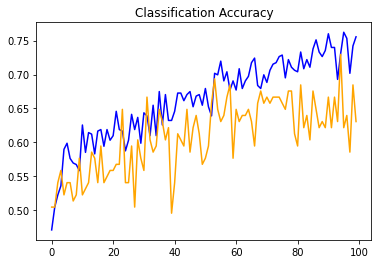

In [39]:
#plot of training and validation accuracy

plt.title('Classification Accuracy')
plt.plot(pred2.history['accuracy'], color='blue', label='train')
plt.plot(pred2.history['val_accuracy'], color='orange', label='val')

Our outputs show us that our fix worked well for our training and validation set however, on our test set we did not get a solid improvement. Our chances of a correct prediction are still about the odds of a coin flip.

In [40]:
#making predictions on teset data with fitted clf2 model

predictions2 = clf2.predict(test)
y_pred2 = np.array((clf2.predict(test) > 0.5).astype("int32"))
y_pred2 = y_pred2.flatten()

Text(33.0, 0.5, 'True Labels')

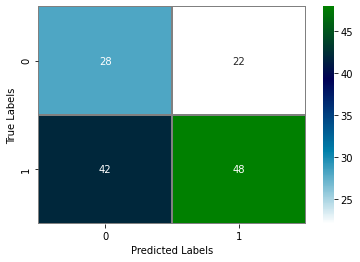

In [41]:
#plotting confusion matrix of clf2 predictions

confusion_matrix(y_pred2, true_class)
sns.heatmap(confusion_matrix(y_pred2,true_class),cmap='ocean_r',annot=True,linewidths=2,linecolor='gray')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

Our final confusion matrix shows a near similar output to our first confusion matrix, only now a few more have been classified correctly compared to our first. 

# Part Two Conclusion

In the end, I felt dissapointed by this portion of my project, I had tried a lot of things but I couldn't quite find what I needed to fix to get the model perfect, and simply just ran out of time to complete it. I think at some point I will come back to this portion and try to solve the issues I had, but I think, at this momement, my lack of experience and knowledge in this subject showed. 

There were other possible isssues as well, possibly a low amount of training pictures provided, unclear images with extra noise in them, or perhaps I just had something wrong in my layers and parameters. If it is at all possible, I would love to get feedback on what I had done right and wrong. I want to succeed in this subject, but to succeed you must also fail, and in my opinion, this is one of those moments. 